# Using Foursquare to generate a targeted list for B2B sales

## Part 1:  Importing data & filter results from Foursquare

#### Business problem

Business to business sales often involves extensive driving for purposes of scouting neighborhoods and identifying target businesses.  Analyzing neighborhoods and visualizing short lists of businesses can help sales staff to visualize target businesses and determine strategic routes.  This can help to increase the number of target businesses reached in a given day.  In a field where success is directly proportional to the number of businesses reached, this can result in a higher ROI on time invested.  In this example I will pretend that I am working with a startup gluten-free baking company that is looking to develop business channels for selling their gluten-free vegetarian brownie.

#### Data requirements

Data needed would be:

*Zip codes that will be targeted*

The datasource for this will be OpenDataSoft (ODS).  The site hosts a [US Zip Code](https://public.opendatasoft.com/explore/dataset/us-zip-codes/table/) file that can be filtered by cities of interest.  From this file, I will need to collect the following features
- Zipcode:  lists all relevant zip codes
- City:  name of city in which the zip code is located
- Lat:  latitude at center point of zip code
- Long: longitude at center point of zip code

*Foursquare data on business locations*

The assumption here is that top results would reflect popularity to some extent.  More popular businesses would correlate with higher potential sales of gluten-free vegetarian brownies through these business channels.  Features of interest would be:
- Business name
- Location latitude
- Location longitude
- Business type or catogory

#### Data collection

##### Collect zip codes

In this example I will focus on analyzing zip codes in New Orleans.  To start, I'll need to import libraries that will:
- allow me to connect to the OpenDataSoft URL
- convert the data received into a palatable dataframe
- enable dataframe manipulation

In [115]:
import pandas as pd
import json
import requests

# transforming json file into pandas dataframe library
from pandas.io.json import json_normalize

I want to make the API connection flexible, so I will set up variables that enable me to change the city and state.

In [116]:
# set up city and state
city = 'New Orleans'
zipcodes = 66 # the API limit is 10 so for a full list of zip codes I matched the number of search results
state = 'LA'

# set up URL to accept city and state as variables
url = "https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-zip-code-latitude-and-longitude&q={}&rows={}&facet=state&facet=timezone&facet=dst&refine.state={}".format(city, zipcodes, state)

# fetch URL
response = requests.get(url)

# validate that connection was successful
print(response.status_code)

200


The status code signals that the connection was successful.  Now I'm ready to create a pandas dataframe using data collected from the API.  By inspecting the dataset on the website, I've identified that zip code data is stored in the records key.

In [117]:
x = response.json() # returns a json object of the result
zipcodes = x['records'] # assigns records from API call to zipcodes
df = pd.json_normalize(zipcodes) # converts result into a palatable dataframe
df.head() # prints first 5 rows from dataframe

,datasetid,recordid,record_timestamp,fields.city,fields.zip,fields.dst,fields.geopoint,fields.longitude,fields.state,fields.latitude,fields.timezone,geometry.type,geometry.coordinates
0,us-zip-code-latitude-and-longitude,2754d6f177556f7c4bdc2f04c400b102df78d3d8,2018-02-09T16:33:38.603000+00:00,New Orleans,70156,1,"[30.032997, -89.882564]",-89.882564,LA,30.032997,-6,Point,"[-89.882564, 30.032997]"
1,us-zip-code-latitude-and-longitude,bb1c8e44694e2766ad81bd1474f81f5d6234ae66,2018-02-09T16:33:38.603000+00:00,New Orleans,70175,1,"[30.032997, -89.882564]",-89.882564,LA,30.032997,-6,Point,"[-89.882564, 30.032997]"
2,us-zip-code-latitude-and-longitude,1824eb231990370b665fb35eb12ab67171df9bd3,2018-02-09T16:33:38.603000+00:00,New Orleans,70146,1,"[30.032997, -89.882564]",-89.882564,LA,30.032997,-6,Point,"[-89.882564, 30.032997]"
3,us-zip-code-latitude-and-longitude,f83cad30ec0abfc4178b7825d4404a66cef65a44,2018-02-09T16:33:38.603000+00:00,New Orleans,70182,1,"[30.067646, -89.815993]",-89.815993,LA,30.067646,-6,Point,"[-89.815993, 30.067646]"
4,us-zip-code-latitude-and-longitude,c2f3aab82b85ef46d7d26bb61c5714a56b15df25,2018-02-09T16:33:38.603000+00:00,New Orleans,70115,1,"[29.927305, -90.10197]",-90.101970,LA,29.927305,-6,Point,"[-90.10197, 29.927305]"


Next I can filter down the dataframe to show only the features of interest

In [118]:
new_orleans_zipcodes = df[
    [
        'fields.city',
        'fields.zip',
        'fields.longitude',
        'fields.latitude'
    ]
]

new_orleans_zipcodes.head()

,fields.city,fields.zip,fields.longitude,fields.latitude
0,New Orleans,70156,-89.882564,30.032997
1,New Orleans,70175,-89.882564,30.032997
2,New Orleans,70146,-89.882564,30.032997
3,New Orleans,70182,-89.815993,30.067646
4,New Orleans,70115,-90.101970,29.927305


The column names aren't very convenient, so I will change those.

In [119]:
#map old values to new values
col_names = {
    'fields.city': 'city',
    'fields.zip': 'zipcode',
    'fields.longitude': 'long',
    'fields.latitude': 'lat'
}

# pass dictionaries to rename method
zipcode_df = new_orleans_zipcodes.rename(columns=col_names)
zipcode_df.head()

,city,zipcode,long,lat
0,New Orleans,70156,-89.882564,30.032997
1,New Orleans,70175,-89.882564,30.032997
2,New Orleans,70146,-89.882564,30.032997
3,New Orleans,70182,-89.815993,30.067646
4,New Orleans,70115,-90.101970,29.927305


In [120]:
city = zipcode_df['city']

# validate that all zipcodes belong to New Orleans
city.value_counts()

New Orleans    66
Name: city, dtype: int64

There API returned 66 zipcodes, and all of them are located within the city limits of New Orleans.

##### Collect venue data

First I need to define my Foursquare credentials

In [121]:
import fs_secrets

In [122]:
CLIENT_ID = fs_secrets.client_id # your Foursquare ID
CLIENT_SECRET = fs_secrets.client_secret # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 # A default Foursquare API limit value

In [123]:
def getNearbyVenues(zipcode, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for zipcode, lat, lng in zip(zipcode, latitudes, longitudes):
            
        # create the API request URL
        fs_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(fs_url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['zipcode', 
                  'zip_lat', 
                  'zip_long', 
                  'venue', 
                  'venue_lat', 
                  'venue_long', 
                  'venue_category']
    
    return(nearby_venues)

Create a dataframe named new_orleans_venues and run the function getNearbyVenues using the zipcodes, latitude, and longitude data from the chicagozip_df dataframe created earlier.

In [124]:
neworleans_venues = getNearbyVenues(zipcode=zipcode_df['zipcode'],
                                  latitudes=zipcode_df['lat'],
                                  longitudes=zipcode_df['long']
                                  )

Preview the results by looking at the shape of the dataframe to see how many venues were returned, and the first 5 rows of the dataframe.

In [125]:
print(neworleans_venues.shape)
neworleans_venues.head()

(1300, 7)


,zipcode,zip_lat,zip_long,venue,venue_lat,venue_long,venue_category
0,70156,30.032997,-89.882564,Barkemeyer Law Firm,30.033591,-89.884306,Lawyer
1,70175,30.032997,-89.882564,Barkemeyer Law Firm,30.033591,-89.884306,Lawyer
2,70146,30.032997,-89.882564,Barkemeyer Law Firm,30.033591,-89.884306,Lawyer
3,70182,30.067646,-89.815993,J Martin Seafood,30.067292,-89.818889,Food
4,70182,30.067646,-89.815993,Environmental Analyst,30.067550,-89.812432,Boat or Ferry


I now have a dataframe of 1300 venues within the 66 zip codes in New Orleans.  With a dataframe of Foursquare venues within 1km of each New Orleans zip code enter in place, I'm ready to move forward with narrowing results to create a short-list of venues to target.  Since there is more than one way to do this, I will use part 1 of this data journey, to find the methods with the least computational burden.

Reviewing available venue categories, I have identified the following business categories as high potential for developing business channels:
- Coffee Shop
- Café
- Dessert Shop
- Vegetarian / Vegan Restaurant
- Fondue Restaurant
- Gluten-free Restaurant

Next I will explore various methods to filter the dataframe to only include these venue categories, and identify the method with the lowest computational burden.

##### Leverage .isin selection to create a filtered list of venues that match the venue categories above

In [132]:
categories = ['Coffee Shop','Café','Dessert Shop','Vegetarian / Vegan Restaurant','Fondue Restaurant','Gluten-free Restaurant']
filtered_neworleans = neworleans_venues[neworleans_venues['venue_category'].isin(categories)]
filtered_neworleans

,zipcode,zip_lat,zip_long,venue,venue_lat,venue_long,venue_category
10,70115,29.927305,-90.10197,French Truck Cafe,29.929239,-90.104610,Café
45,70115,29.927305,-90.10197,Mojo Coffee House,29.935092,-90.106383,Coffee Shop
46,70115,29.927305,-90.10197,Yogurtland,29.924917,-90.108316,Dessert Shop
49,70115,29.927305,-90.10197,Bearcat Cafe,29.935653,-90.104042,Coffee Shop
58,70115,29.927305,-90.10197,Rook Cafe,29.935027,-90.104727,Café
...,...,...,...,...,...,...,...
1269,70127,30.033475,-89.97736,PJ's Coffee,30.034993,-89.973959,Coffee Shop
1278,70127,30.033475,-89.97736,Julies Kitchen,30.031513,-89.971962,Café
1283,70123,29.952605,-90.20536,Starbucks,29.951572,-90.214060,Coffee Shop
1285,70123,29.952605,-90.20536,Starbucks,29.956446,-90.206528,Coffee Shop


## Part 2:  Visualize results

First I will look at the venue counts by zip code and create a bar chart of the results.

In [133]:
# set up dataframe that counts venues by zip code and sorts values in ascending order
zip_count = filtered_neworleans.value_counts('zipcode').sort_values(ascending=True)
zip_count

zipcode
70125     1
70144     2
70127     2
70199     2
70113     2
70124     2
70123     3
70163     3
70118     4
70117     4
70158     5
70116     6
70112     6
70140     7
70119     8
70115     8
70155     9
70130    11
dtype: int64

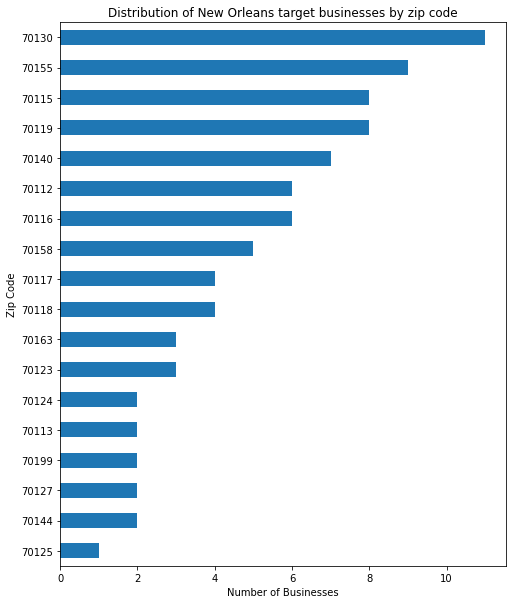

In [134]:
# import libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

# set up chart

zip_count.plot(kind='barh', figsize=(8, 10))

# set up labels
plt.ylabel('Zip Code') # add x-label to the plot
plt.xlabel('Number of Businesses')
plt.title('Distribution of New Orleans target businesses by zip code')

# show chart
plt.show()

This gives me a high level view of total target venues by zip code.  I also want to take a look at the distribution across venue categories.

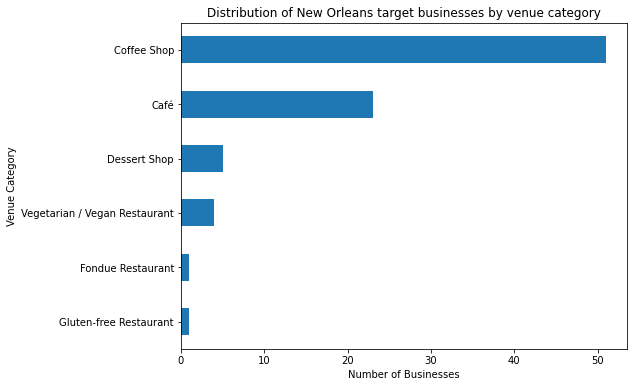

In [135]:
# set up dataframe that counts venues by zip code and sorts values in ascending order
cat_count = filtered_neworleans.value_counts('venue_category').sort_values(ascending=True)

# set up chart
cat_count.plot(kind='barh', figsize=(8, 6))

# set up labels
plt.ylabel('Venue Category') # add x-label to the plot
plt.xlabel('Number of Businesses')
plt.title('Distribution of New Orleans target businesses by venue category')

# show chart
plt.show()

The most common venue category by far is coffee shops followed by cafe's.  I'd also be interested in seeing how venue types are distributed within these numbers and across these zip codes.  First I'll need to create a count of each venue category by zip code.

In [136]:
# create a new dataframe that groups results by zip code and venue category with venue count for each as the value
venue_catcount = filtered_neworleans.groupby(['zipcode','venue_category']).agg({'venue':'count'}).reset_index()

# view first 10 rows of dataframe
venue_catcount.head(10)

,zipcode,venue_category,venue
0,70112,Café,2
1,70112,Coffee Shop,4
2,70113,Café,1
3,70113,Coffee Shop,1
4,70115,Café,2
5,70115,Coffee Shop,4
6,70115,Dessert Shop,1
7,70115,Gluten-free Restaurant,1
8,70116,Café,2
9,70116,Coffee Shop,4


Next I will create a pivot table from the venue_catcount dataframe since it will be easier to call columns.

In [137]:
catcount_pivot = venue_catcount.pivot_table(index='zipcode',
                                           columns='venue_category',
                                           values='venue',
                                           aggfunc='sum',
                                           fill_value=0)
catcount_pivot.reset_index()
catcount_pivot

venue_category,Café,Coffee Shop,Dessert Shop,Fondue Restaurant,Gluten-free Restaurant,Vegetarian / Vegan Restaurant
zipcode,,,,,,
70112,2,4,0,0,0,0
70113,1,1,0,0,0,0
70115,2,4,1,0,1,0
70116,2,4,0,0,0,0
70117,0,2,1,0,0,1
70118,1,2,1,0,0,0
70119,1,4,1,0,0,2
70123,0,2,1,0,0,0
70124,0,2,0,0,0,0


Now I'll create a bar chart that shows a count of venues by venue category for each zip code.

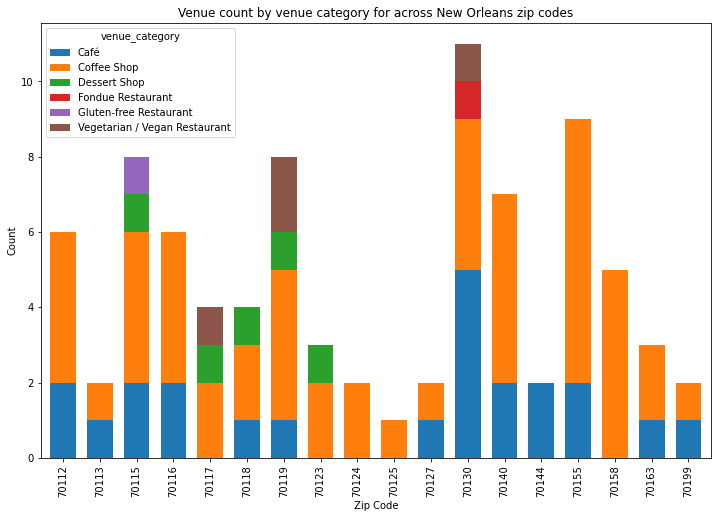

In [139]:
# create bar chart
catcount_pivot.plot(
    kind='bar',
    stacked=True,
    figsize = (12,8),
    width = 0.7

)

#set up labels
plt.xlabel('Zip Code')
plt.ylabel('Count')
plt.title ('Venue count by venue category for across New Orleans zip codes')

# show chart
plt.show()

Based on this it looks like the, with the exception of zip code 70155, the zip codes with the highest number of venues would also enable a test of business channels across multiple venue categories.  Zip code 70115, for example, has cafes, coffee shops, as well as a gluten free restaurant and a dessert shop.  Zip code 70119 is similar, except it has 2 vegetarian/vegan restaurants instead of a gluten free restaurant.  Interestingly, some of the zip codes that fall in the middle with regards to total venue count, have less diversity in venue categories.  Zip codes 70112, 70116 and 70140 only have cafes and coffee shops while 70158 only has coffee shops.  Even though zip codes 70117 and 70118 have a lower total number of venues, the venues for each of these zip codes are distributed across 3 venue categories.

Finally I will use folium to plot these venues on a map.

In [154]:
#import folium
import folium # plotting library

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import html

In [155]:
#look up chicago coordinates

address = "New Orleans, LA"

geolocator = Nominatim(user_agent="neworleans_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

29.9499323 -90.0701156


In [159]:
neworleans_map = folium.Map(location=[latitude, longitude], zoom_start=11) # generate map centred around city center

# add New Orleans city center as a red circle mark
folium.CircleMarker(
    [latitude, longitude],
    radius=5,
    popup='New Orleans',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.5
    ).add_to(neworleans_map)


# add venues to the map as black circles
for lat, long, label in zip(filtered_neworleans['venue_lat'], filtered_neworleans['venue_long'], filtered_neworleans['venue']):
    folium.CircleMarker(
        [lat, long],
        radius=2,
        popup=html.escape(label),
        fill=True,
        color='black',
        fill_color='black',
        fill_opacity=0.5
        ).add_to(neworleans_map)

# display map
neworleans_map